In [1]:
### Definining name of analysis ###
name = '2023-07-06_CREATeVCruising'
data_path = '../data/'
data_folder = 'createv-2023-07-06'
file_name = '00000012.BIN'
datasave_path = data_path+data_folder+'/'
result_path = '../Results/'+name+'/'
figure_path = '../Figures/'+name+'/'

In [2]:
from os import sys
import os
sys.path.append('../')

# Getting packages #
%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize 
from scipy.io import savemat

import plotly.express as px

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

import data_exporter
import datetime

### Creating Folders for Results/Data ###
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [3]:
# Setting Plot Defaults
plt.style.use('../basic_plotter.mplstyle')

In [4]:
# Importing data, specifying import characteristics, backing up results
rate = "10ms"
interpolateM = "linear"
processor = "CREATeV_2023"

rawdata_name = data_folder+'/'+file_name.split('.')[0]+'_'+rate+'_'+interpolateM+'_'+processor+'.pkl'

# Checking if the data is already pickled for analysis
if os.path.exists(data_path+rawdata_name):
    df = pd.read_pickle(data_path+rawdata_name)
else:
    df = main.get_data(processor, data_folder+'/'+file_name, rate)
    df = df.interpolate(method=interpolateM)
    pd.to_pickle(df, data_path+rawdata_name) # Storing parsed data

In [5]:
# Vehicle parameters
prop = propellers.aeronaut20x8() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.502 # Estimated with virtual bolt included
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

P_systems = 0.3 # Amount of power consumed by everything except the ESC & motor

highorderpolar = True

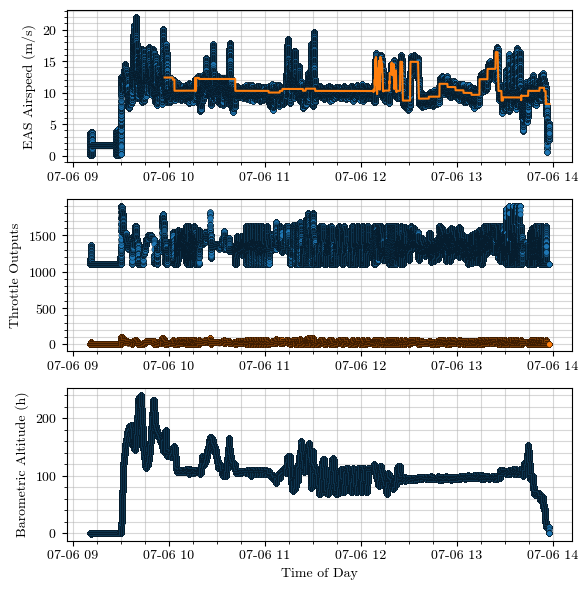

In [6]:
# Generating Plots
timeindex_v_thr_h = plt.figure(figsize=(6,6))

ax0 = plt.subplot(3,1,1)
plt.grid("On")
plt.plot(df.index, df.Airspeed_Sensor0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.plot(df.index, df.Airspeed_Demanded, linestyle='-', marker='', markersize=4, markeredgecolor=[0,0,0])
plt.ylabel("EAS Airspeed (m/s)")
ax1 = plt.subplot(3,1,2, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.ThrottleOut, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.plot(df.index, df.Throttle, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.ylabel("Throttle Outputs")
ax2 = plt.subplot(3,1,3, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.Altitude_BARO_0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.ylabel("Barometric Altitude (h)")
plt.xlabel("Time of Day")
plt.grid("On")
plt.show()

#main.save_figure(timeindex_v_thr_h, f'{timeindex_v_thr_h=}'.split('=')[0], figure_path)

### Segmentation of Cruising Data

Cruise begun at 12:24:40 GMT.  Segment starts (settled demanded airspeed changes), settled time (settle actual airspeed to demanded), and end times (jumping to new demanded airspeed) were recorded based on the figure above.  Airspeed hold was poor, in particular for the higher airspeeds. The maximum throttle was too low to reach the necessary top airspeed of 16 m/s, and should be considered a negative to the method!  

In [7]:
## Generating Map Plots Descending ## 
token = "pk.eyJ1Ijoid2tlbXA5NCIsImEiOiJjbGI0NHJuemkwMmF2M29zM24xcTlpNXVjIn0.qSiAc29MftNSOK2DOpRggw"
color_scale = [(0, 'orange'), (1,'red')]
df_example = df[1170000:1180000]

fig = px.scatter_mapbox(df_example, 
                        lat="Latitude", 
                        lon="Longitude", 
                        hover_name=df_example.index, 
                        #hover_data=["Address", "Listed"],
                        color="Airspeed_Demanded",
                        color_continuous_scale='jet',
                        #size="Listed",
                        zoom=15.5, 
                        height=600,
                        width=1000,
                        labels={"Airspeed": 'Airspeed (m/s)'},
                        center={'lat':44.0427, 'lon':-79.845},
                        template='presentation')
fig.update_layout(mapbox_style="satellite", mapbox_accesstoken=token)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

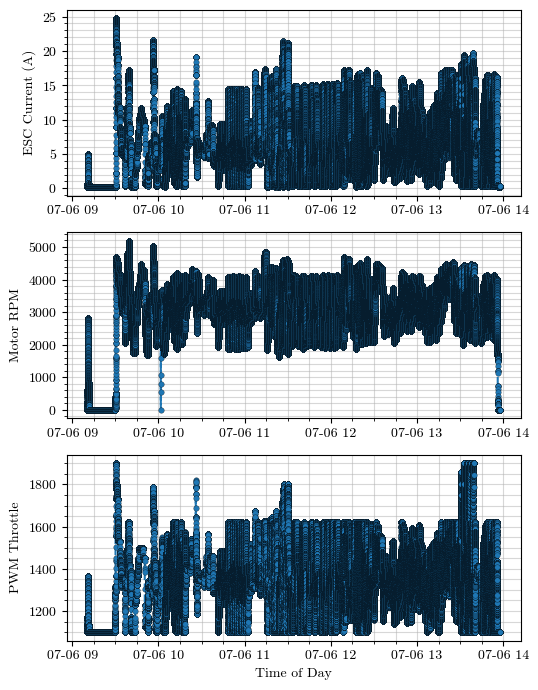

In [8]:
# Plotting Propulsion Information
timeindex_I_RPM_thr = plt.figure(figsize=(5.5,7))

ax0 = plt.subplot(3,1,1)
ax0.plot(df.index, df.MainBatteryCurrent, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
ax0.set_ylabel("ESC Current (A)")
ax1 = plt.subplot(3,1,2, sharex=ax0)
ax1.plot(df.index, df.MotorRPM, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
ax1.set_ylabel("Motor RPM")
ax2 = plt.subplot(3,1,3, sharex=ax0)
ax2.plot(df.index, df.ThrottleOut, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
ax2.set_ylabel("PWM Throttle")
ax2.set_xlabel("Time of Day")
plt.show()

#main.save_figure(timeindex_I_RPM_thr, f'{timeindex_I_RPM_thr=}'.split('=')[0], figure_path)

In [9]:
### Mask Initialization ###

# Generating Start/End Times for Segments #
# Producing mask_array for dataframe

# def get_mask(df, start, end, year, month, day):
#     # Getting boolean mask from start and end times
#     start_time = get_datetime(start, year, month, day)
#     end_time = get_datetime(end, year, month, day)
#     mask = (df.index > start_time) & (df.index < end_time)
#     return mask

# def get_datetime(hour_string, year, month, day):
#     # Results completed datetime from hour string, and date
#     split_nums = hour_string.split(':')
#     hours = int(split_nums[0])
#     minutes = int(split_nums[1])
#     seconds = int(split_nums[2])
#     return pd.Timestamp(year=year, month=month, day=day, hour=hours, minute=minutes, second=seconds)

year = 2023
month = 7
day = 6

# Acceleration Masking from the above figures
seg_times = np.array([['12:25:00', '12:25:47'],
                        ['12:26:35', '12:30:47'],
                        ['12:31:13', '12:35:47'],
                        ['12:36:37', '12:42:27'],
                        ['12:42:30', '12:45:22'],
                        ['12:49:30', '12:54:08'],
                        ['12:54:17', '12:59:08'],
                        ['12:59:19', '13:04:08'],
                        ['13:04:13', '13:09:08'],
                        ['13:09:12', '13:14:08'],
                        ['13:14:21', '13:19:08'],
                        ['13:19:15', '13:24:08'],
                        ['13:24:23', '13:25:29']])
# seg_zeroing = np.array([['9:27:39','9:41:45']])
mask_array = []
acc_mask_array = []
for i in range(np.shape(seg_times)[0]):
    mask = cl_finders.get_mask(df, seg_times[i,0], seg_times[i,1], year, month, day)
    mask_array.append(mask)
# for i in range(np.shape(seg_zeroing)[0]):
#     mask = cl_finders.get_mask(df, seg_zeroing[i,0], seg_zeroing[i,1], year, month, day)
#     acc_mask_array.append(mask)

In [10]:
############# Main Analysis ###############3
g = 9.807
# Attitude 
phi = np.deg2rad(df.RollAngle.to_numpy())            # Bank angle in radians
theta = np.deg2rad(df.PitchAngle.to_numpy())         # Pitch angle in radians

# Inertial Measurement Unit
U_dot = df.XAcc_IMU0.to_numpy()                       # Acceleration in X direction

# Atmospheric adjustments:
rho = df.Pressure_BARO0.to_numpy() * (287 * (df.Temperature_ARSP.to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df.Airspeed_Sensor0.to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df.Altitude_POS.to_numpy()                   # Altitude
Vd_eas = df.DescentRate.to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed

# Ground speed limiter
v_dem = df["Airspeed_Demanded"].to_numpy()

# Propulsion characterization
n = df.MotorRPM.to_numpy() / 60                               # Revolutions per second
i_esc = df.EscCurrent.to_numpy()
v_esc = df.EscVoltage.to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Inertial Measurement Unit
xp_acc = df.XAcc_IMU0.to_numpy()                       # Acceleration in X direction of the IMU
yp_acc = df.YAcc_IMU0.to_numpy()                       # Acceleration in Y direction of the IMU
zp_acc = df.ZAcc_IMU0.to_numpy()                       # Acceleration in Z direction of the IMU

U_dot = xp_acc - g * np.sin(theta)
V_dot = yp_acc + (9.807 * np.cos(theta) * np.sin(phi))
W_dot = zp_acc + g * np.cos(theta) * np.cos(phi)

gamma = np.arcsin(-Vd_tas/v_tas)
alpha = gamma + theta

U = v_tas * np.cos(alpha)
V = 0
W = v_tas * np.sin(alpha)

P = df.GyroX_IMU0 
Q = df.GyroY_IMU0
R = df.GyroZ_IMU0

# Estimated propulsive power (New Fitting)
P_eta = cl_finders.eta_steady(prop, motor, v_tas, n, i_esc, v_esc)
P_ct = cl_finders.thrust_steady(prop, rho, v_tas, n)
# P_desc = cl_finders.desc2preq(createv, prop, rho, v_tas, n, q, Vd_tas)

# P_desc_acc = cl_finders.descU2preq(createv, prop, rho, v_tas, n, q, Vd_tas, pitch, U_dot)
P_hybrid = cl_finders.cruise_highorder(createv, prop, rho, v_tas, Vd_tas, n, theta, U_dot)

# Getting drag coefficient
Cd_eta = cl_finders.preq2cd(createv, v_tas, q, P_eta)
Cd_ct = cl_finders.preq2cd(createv, v_tas, q, P_ct)
# Cd_desc = cl_finders.preq2cd(createv, v_tas, q, P_desc)
# Cd_desc_acc = cl_finders.preq2cd(createv, v_tas, q, P_desc_acc)

Cd_hybrid = cl_finders.preq2cd(createv, v_tas, q, P_hybrid)

# Getting lift coefficient
CL = cl_finders.cl_banked(createv, q, phi)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_2912/1493159388.py:11: RuntimeWarning:

invalid value encountered in reciprocal

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_2912/1493159388.py:13: RuntimeWarning:

invalid value encountered in reciprocal

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_2912/1493159388.py:19: RuntimeWarning:

invalid value encountered in reciprocal

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_2912/1493159388.py:28: RuntimeWarning:

divide by zero encountered in true_divide

/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../propellers.py:39: RuntimeWarning:

invalid value encountered in subtract

/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../propellers.py:44: RuntimeWarning:

invalid value encountered in add

/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../motors.py:53: RuntimeWarning:

divide by zero encounter

Main goal of this analysis is to replicate the methods used from 2023, with steady cruising flight.  Looks like there are some issues with the estimation of the Cd_eta.  Actually no, just some errors in which type of masking to use to segment.  

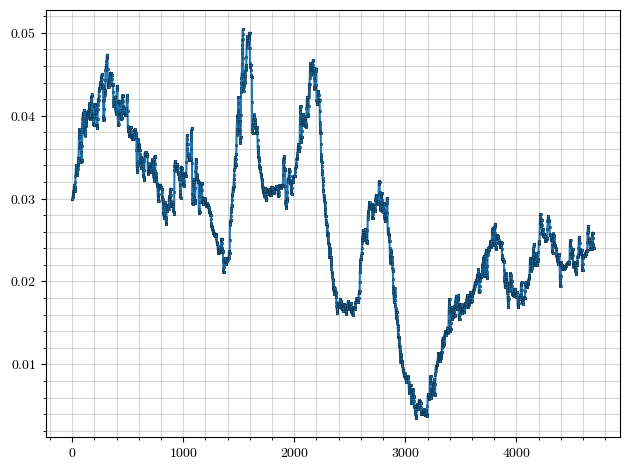

In [11]:
plt.figure()
plt.plot(Cd_eta[mask_array[0]])
plt.show()

In [12]:
# Collecting all CL, CD data points for cruising, plotting with better visuals

def collect_timesegments(variable, mask_array):
    total = np.array([])
    for i in range(len(mask_array)):
        total = np.append(total, variable[mask_array[i]])
    return total

# Cruise drag data
cd_total_eta = collect_timesegments(Cd_eta, mask_array)
cd_total_ct = collect_timesegments(Cd_ct, mask_array)
# Cruise lift data
cl_total_cruise = collect_timesegments(CL, mask_array)

# Binning averages
bins = np.linspace(0.05, 1.4, 51)
digitized_cruise = np.digitize(cl_total_cruise, bins)

# Lift binning/averaging
cl_means_cruise = [cl_total_cruise[digitized_cruise == i].mean() for i in range(1, len(bins))]
# Drag averaging
cd_means_eta = [cd_total_eta[digitized_cruise == i].mean() for i in range(1, len(bins))]
cd_means_ct = [cd_total_ct[digitized_cruise == i].mean() for i in range(1, len(bins))]

# Lift standard deviation
cl_stds_cruise = [cl_total_cruise[digitized_cruise == i].std() for i in range(1, len(bins))]
# Drag standard deviation
cd_stds_eta = [cd_total_eta[digitized_cruise == i].std() for i in range(1, len(bins))]
cd_stds_ct = [cd_total_ct[digitized_cruise == i].std() for i in range(1, len(bins))]

# Calculation of confidence intervals
#cd_ci95_desc[i] = 1.96 * cd_stds_eta * (np.sqrt(len(Cd_ct[masks[i]])) **-1)
cd_ci95_eta = [ 1.96 * (np.sqrt(len(digitized_cruise == i)))**-1 * cd_total_eta[digitized_cruise == i].std() for i in range(1, len(bins)) ]
cd_ci95_ct = [ 1.96 * (np.sqrt(len(digitized_cruise == i)))**-1 * cd_total_ct[digitized_cruise == i].std() for i in range(1, len(bins)) ]

cl_ci95_cruise = [ 1.96 * (np.sqrt(len(digitized_cruise == i)))**-1 * cl_total_cruise[digitized_cruise == i].std() for i in range(1, len(bins)) ]


/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_2912/1978313427.py:20: RuntimeWarning:

Mean of empty slice.

/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_2912/1978313427.py:22: RuntimeWarning:

Mean of empty slice.

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_2912/1978313427.py:23: RuntimeWarning:

Mean of empty slice.

/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:262: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning:

invalid value encountered in true_divide

/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:254: RuntimeWarni

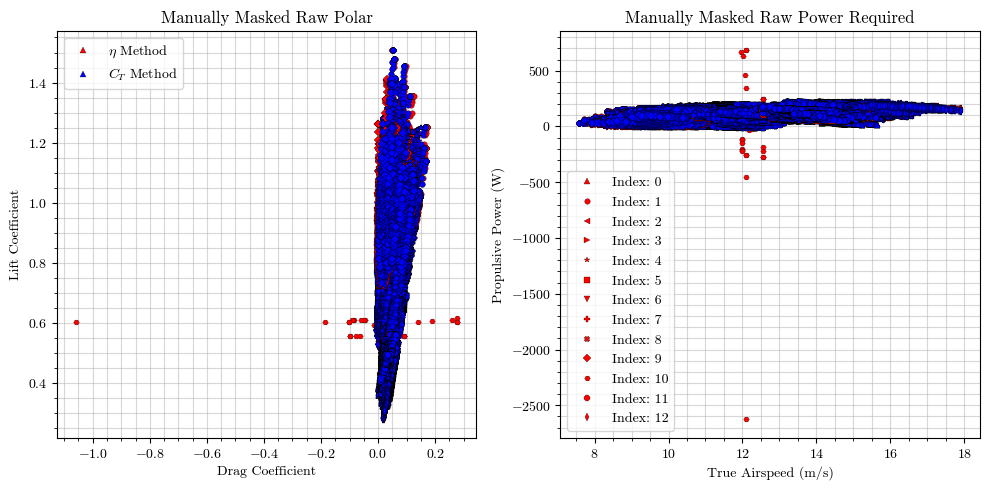

Plot already exists


In [13]:
# Plotting Raw Polar Results + Raw Power Results

rawpolar_rawpower = plt.figure(figsize=(10,5))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(1,2,2)

ax0.set_title("Manually Masked Raw Polar")
markers = ['^', 'o', '<', '>', '*', 's', 'v', 'P', 'X', 'D', 'H', '8', 'd', 'p']
for i in range(len(mask_array)):
    ax0.plot(Cd_eta[mask_array[i]], CL[mask_array[i]], linestyle='', marker=markers[i], markerfacecolor='r', markersize=4, markeredgecolor=[0,0,0])
    ax0.plot(Cd_ct[mask_array[i]], CL[mask_array[i]], linestyle='', marker=markers[i], markerfacecolor='b', markersize=4, markeredgecolor=[0,0,0])
ax0.set_ylabel("Lift Coefficient")
ax0.set_xlabel("Drag Coefficient")
ax0.legend(['$\eta$ Method', '$C_T$ Method'])

ax1.set_title("Manually Masked Raw Power Required")
for i in range(len(mask_array)):
    ax1.plot(v_tas[mask_array[i]], P_eta[mask_array[i]], label="Index: "+str(i), linestyle='', marker=markers[i], markerfacecolor='r', markersize=4, markeredgecolor=[0,0,0])
    ax1.plot(v_tas[mask_array[i]], P_ct[mask_array[i]], linestyle='', marker=markers[i], markerfacecolor='b', markersize=4, markeredgecolor=[0,0,0])
ax1.set_xlabel("True Airspeed (m/s)")
ax1.set_ylabel("Propulsive Power (W)")
ax1.legend()
plt.show()

main.save_figure(rawpolar_rawpower, f'{rawpolar_rawpower=}'.split('=')[0], figure_path)

In [14]:
# Loitering mask
CDct_ave = np.zeros(len(mask_array))
CDeta_ave = np.zeros(len(mask_array))
CDhybrid_ave = np.zeros(len(mask_array))

CL_ave = np.zeros(len(mask_array))
EAS_ave = np.zeros(len(mask_array))

pitch_ave = np.zeros(len(mask_array))

CDct_std = np.zeros(len(mask_array))
CDeta_std = np.zeros(len(mask_array))
CL_std = np.zeros(len(mask_array))
EAS_std = np.zeros(len(mask_array))

# Getting 95% confidence interval
CDct_95 = np.zeros(len(mask_array))
CDeta_95 = np.zeros(len(mask_array))
CL_95 = np.zeros(len(mask_array))
EAS_95 = np.zeros(len(mask_array))

for i in range(len(mask_array)):
    
    CDeta_ave[i] = np.mean(Cd_eta[mask_array[i]])
    CDct_ave[i] = np.mean(Cd_ct[mask_array[i]])
    CDhybrid_ave[i] = np.mean(Cd_hybrid[mask_array[i]])

    CL_ave[i] = np.mean(CL[mask_array[i]])
    EAS_ave[i] = np.mean(v_eas[mask_array[i]])
    pitch_ave[i] = np.mean(theta[mask_array[i]])
    
    CDeta_std[i] = np.std(Cd_eta[mask_array[i]])
    CDct_std[i] = np.std(Cd_ct[mask_array[i]])
    CL_std[i] = np.std(CL[mask_array[i]])
    EAS_std[i] = np.std(v_eas[mask_array[i]])

    # Finding 95% Confidence Interval
    CDct_95[i] = 1.96 * CDct_std[i] * (np.sqrt(len(Cd_ct[mask_array[i]])) **-1)
    CDeta_95[i] = 1.96 * CDeta_std[i] * (np.sqrt(len(Cd_eta[mask_array[i]])) **-1)
    CL_95[i] = 1.96 * CL_std[i] * (np.sqrt(len(CL[mask_array[i]])) **-1)
    EAS_95[i] = 1.96 * EAS_95[i] * (np.sqrt(len(v_eas[mask_array[i]])) **-1)

# Finding drag polar:
polar_eta = cl_finders.cd2polar(createv, CDeta_ave, CL_ave,highorder=highorderpolar)
polar_ct = cl_finders.cd2polar(createv, CDct_ave, CL_ave, highorder=highorderpolar)
polar_hybrid = cl_finders.cd2polar(createv, CDhybrid_ave, CL_ave, highorder=highorderpolar)

# Finding power required @ SSL @ Standard weight of 12.6 kg
Peq_eta, EAS = cl_finders.polar2preqew(createv, polar_eta, (8,14))
Peq_ct, EAS = cl_finders.polar2preqew(createv, polar_ct, (8,14))
Peq_hybrid, EAS = cl_finders.polar2preqew(createv, polar_hybrid, (8,14))

# Finding AOA correlation to Coefficient of Lift:
CL_alpha = cl_finders.angleModel(CL_ave, pitch_ave, "linear")
EAS_model, CL_model, CD_model, AoA_model = cl_finders.basicModel(createv, polar_ct, CL_alpha, (8,14))


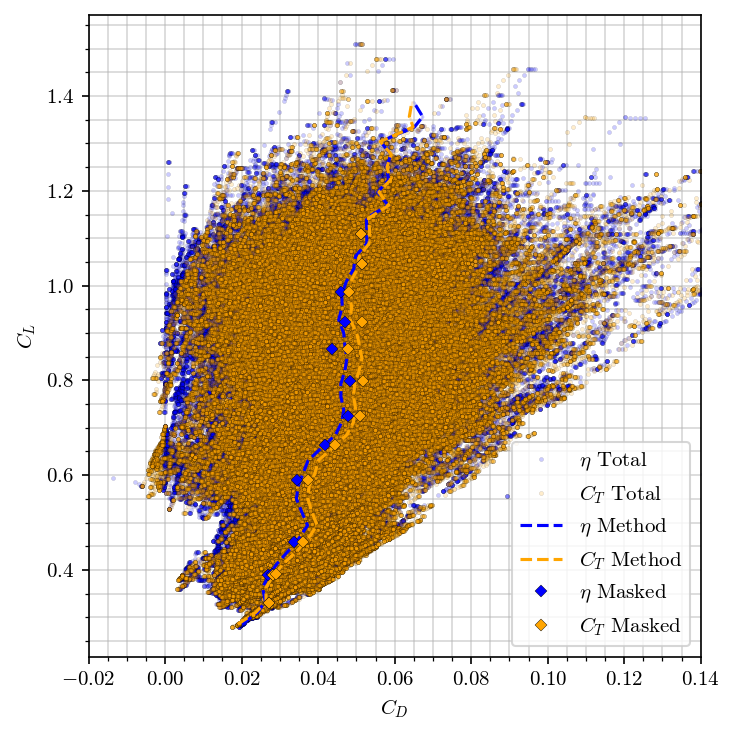

In [15]:
raw_ave_polarw_confint = plt.figure(figsize=(5,5), dpi=150)
plt.plot(cd_total_eta, cl_total_cruise, linestyle='', marker='.', color = 'blue', alpha = 0.2, label='$\eta$ Total')
plt.plot(cd_total_ct, cl_total_cruise, linestyle='', marker='.', color='orange', alpha = 0.2, label='$C_T$ Total')
plt.plot(cd_means_eta, cl_means_cruise, linestyle='--', color='blue', marker='', label='$\eta$ Method')
plt.plot(cd_means_ct, cl_means_cruise, linestyle='--', color='orange', marker='', label='$C_T$ Method')
plt.fill_betweenx(cl_means_cruise, np.array(cd_means_eta) - np.array(cd_ci95_eta), np.array(cd_means_eta) + np.array(cd_ci95_eta), color='blue', alpha=0.2)
plt.fill_betweenx(cl_means_cruise, np.array(cd_means_ct) - np.array(cd_ci95_ct), np.array(cd_means_ct) + np.array(cd_ci95_ct), color='orange', alpha=0.2)
# Plotting manually masked and averaged data points
plt.plot(CDeta_ave, CL_ave, linestyle='', marker='D', color = 'blue', label='$\eta$ Masked')
plt.plot(CDct_ave, CL_ave, linestyle='', marker='D', color='orange', label='$C_T$ Masked')

plt.legend()
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.xlim([-0.02, 0.14])
plt.show()

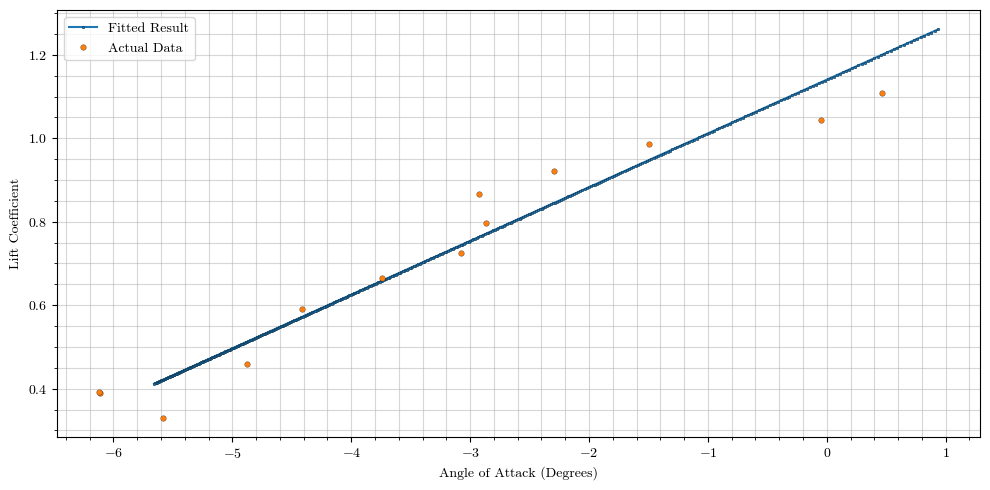

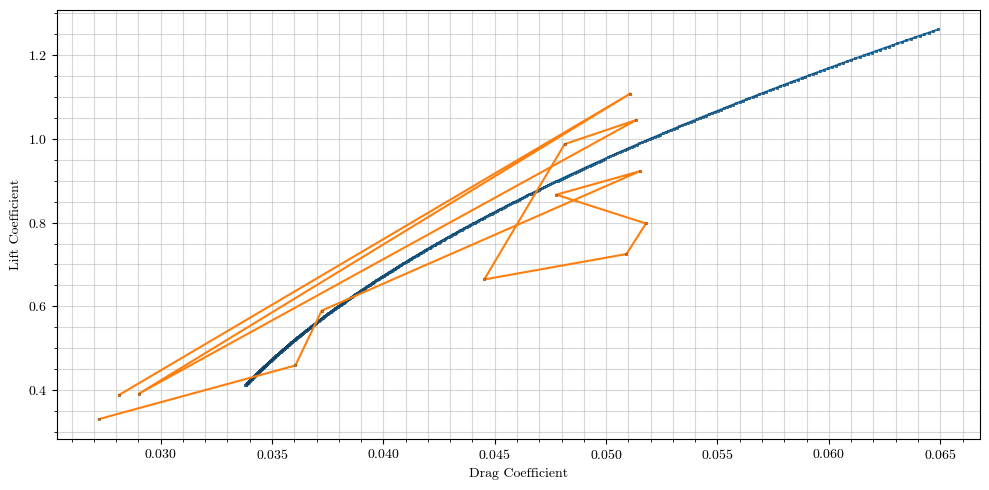

In [16]:
plt.figure(figsize=(10,5))
plt.plot(AoA_model, CL_model, label='Fitted Result')
plt.plot(np.rad2deg(pitch_ave), CL_ave, linestyle='None', marker='o', label='Actual Data')
plt.legend()
plt.xlabel("Angle of Attack (Degrees)")
plt.ylabel("Lift Coefficient")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(CD_model, CL_model, label="Fitted Result")
plt.plot(CDct_ave, CL_ave, label="Raw Data")
plt.xlabel("Drag Coefficient")
plt.ylabel("Lift Coefficient")
plt.grid(True)
plt.show()


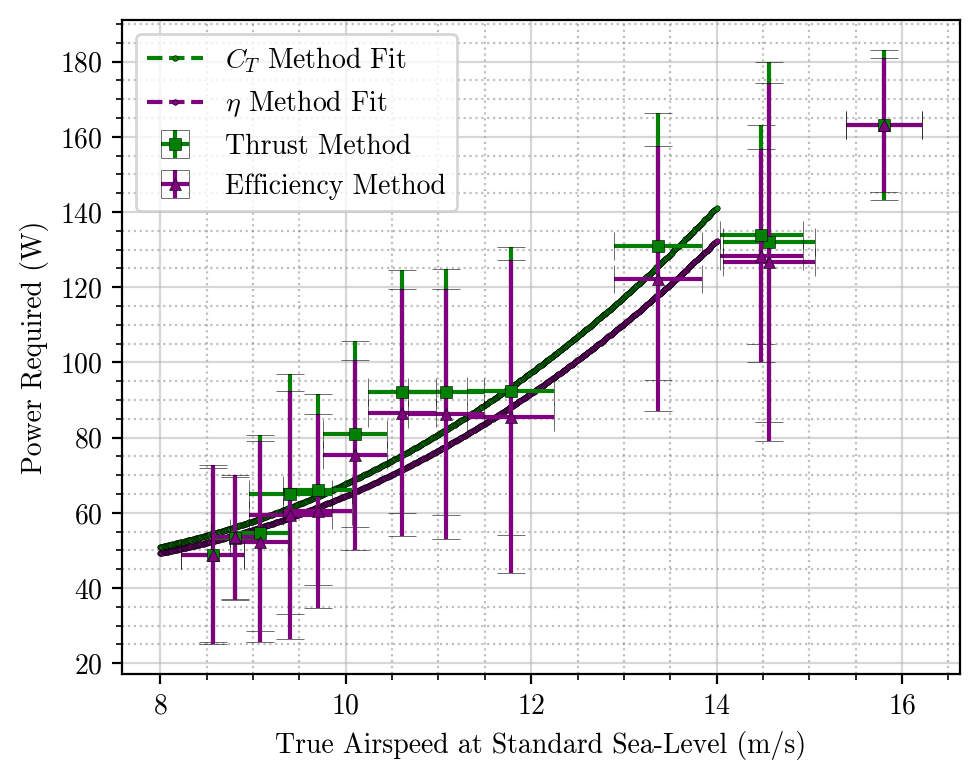

In [17]:
# Plot of Power Required Fits and Data #

plt.figure(figsize=(5,4), dpi=200)
plt.plot(EAS, Peq_ct, label="$C_T$ Method Fit", color='green', linestyle='--')
plt.plot(EAS, Peq_eta, label="$\eta$ Method Fit", color='purple', linestyle='--')

plt.errorbar(EAS_ave, CDct_ave * 0.5 * 1.225 * EAS_ave**3 * createv.area, xerr=EAS_std, yerr=CDct_std* 0.5 * 1.225 * EAS_ave**3 * createv.area, capsize=5, fmt='sg', label="Thrust Method", markeredgecolor=[0,0,0])
plt.errorbar(EAS_ave, CDeta_ave * 0.5 * 1.225 * EAS_ave**3 * createv.area, xerr=EAS_std, yerr=CDeta_std* 0.5 * 1.225 * EAS_ave**3 * createv.area, capsize=5, fmt='^', color='purple', label="Efficiency Method", markeredgecolor=[0,0,0])

plt.xlabel("True Airspeed at Standard Sea-Level (m/s)")
plt.ylabel("Power Required (W)")
plt.legend()
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.show()


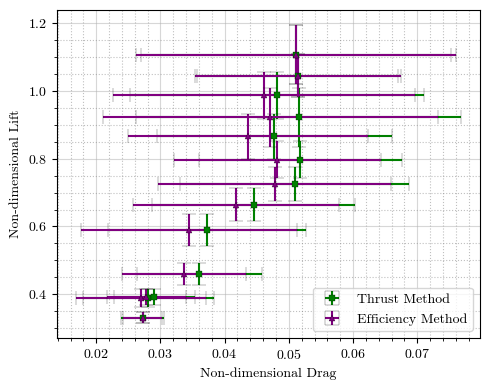

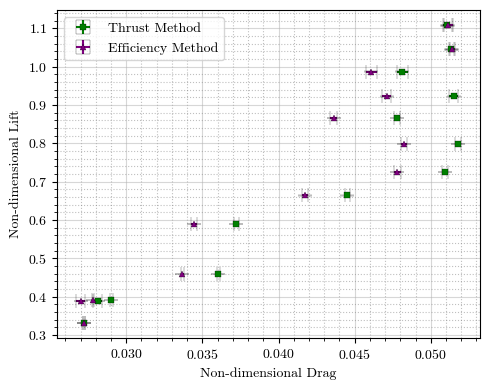

In [18]:
# Drag Polar plots #
plt.figure(figsize=(5,4))
plt.errorbar(CDct_ave, CL_ave, xerr=CDct_std, yerr=CL_std, capsize=5, fmt='sg', label="Thrust Method", markeredgecolor=[0,0,0])
plt.errorbar(CDeta_ave, CL_ave, xerr=CDeta_std, yerr=CL_std, capsize=5, fmt='^', color='purple', label="Efficiency Method", markeredgecolor=[0,0,0])
plt.xlabel("Non-dimensional Drag")
plt.ylabel("Non-dimensional Lift")
plt.legend()
plt.grid(True)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.tight_layout
plt.show()
#plt.savefig("Figures/polar_scatter_pres.pdf", bbox_inches='tight')


# 95% Confidence Interval!

plt.figure(figsize=(5,4))
plt.errorbar(CDct_ave, CL_ave, xerr=CDct_95, yerr=CL_95, capsize=5, fmt='sg', label="Thrust Method", markeredgecolor=[0,0,0])
plt.errorbar(CDeta_ave, CL_ave, xerr=CDeta_95, yerr=CL_95, capsize=5, fmt='^', color='purple', label="Efficiency Method", markeredgecolor=[0,0,0])
plt.xlabel("Non-dimensional Drag")
plt.ylabel("Non-dimensional Lift")
plt.legend()
plt.grid(True)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.tight_layout
plt.show()

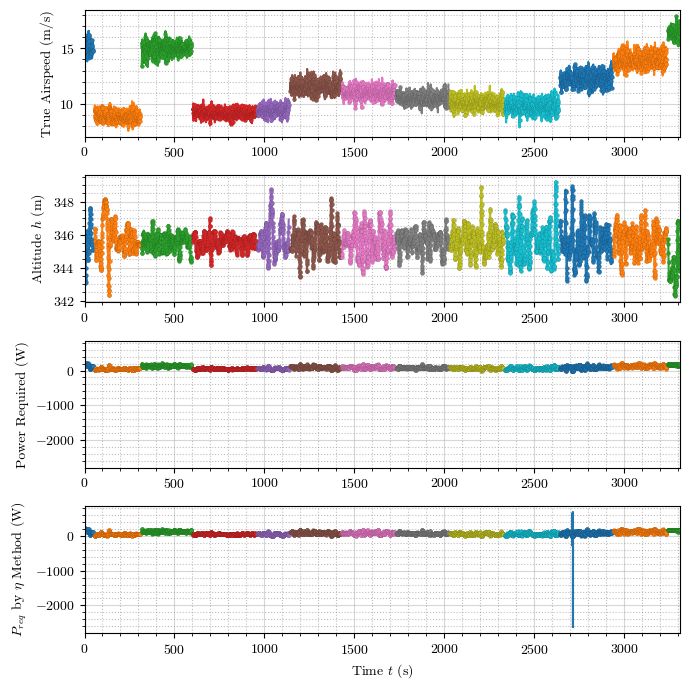

In [19]:
# Plotting Steady-level Data Runs #
markerstyle = 'o'
markerevery = 80
markedgew = 0.05
plt.figure(figsize=(7,7))
ax1 = plt.subplot(4,1,1)
t_init = 0
for i in range(len(mask_array)):
    time_s = np.linspace(t_init, (len(v_tas[mask_array[i]])-1)/100 + t_init, len(v_tas[mask_array[i]]))
    ax1.plot(time_s, v_tas[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("True Airspeed (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax0 = plt.subplot(4,1,2, sharex=ax1)
t_init = 0
for i in range(len(mask_array)):
    time_s = np.linspace(t_init, (len(v_tas[mask_array[i]])-1)/100 + t_init, len(v_tas[mask_array[i]]))
    ax0.plot(time_s, h[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax0.set_ylabel("Altitude $h$ (m)")
ax0.grid(which='major', linestyle='-')
ax0.grid(which='minor', linestyle=':', color='grey')
ax0.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(4,1,3, sharex=ax1)
t_init = 0
for i in range(len(mask_array)):
    time_s = np.linspace(t_init, (len(v_tas[mask_array[i]])-1)/100 + t_init, len(v_tas[mask_array[i]]))
    ax2.plot(time_s, P_ct[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("Power Required (W)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)

ax3 = plt.subplot(4,1,4, sharex=ax1, sharey=ax2)
t_init = 0
for i in range(len(mask_array)):
    time_s = np.linspace(t_init, (len(v_tas[mask_array[i]])-1)/100 + t_init, len(v_tas[mask_array[i]]))
    ax3.plot(time_s, P_eta[mask_array[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax3.set_ylabel("$P_{req}$ by $\eta$ Method (W)")
ax3.set_xlabel("Time $t$ (s)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
ax3.autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()
plt.show()

In [20]:
# Re-doing the analysis with functions

cl_total = cl_finders.total_segments_boolean(CL, mask_array)
cd_eta_total = cl_finders.total_segments_boolean(Cd_eta, mask_array)
cd_ct_total = cl_finders.total_segments_boolean(Cd_ct, mask_array)

bins = np.linspace(0.2, 1.4, 51)

[cl_means_eta, cl_stds_eta, cl_ci95s_eta, cd_means_eta, cd_stds_eta, cd_ci95s_eta] = cl_finders.collect_segments(mask_array, CL, Cd_eta)
[cl_means_eta_bin, cl_stds_eta_bin, cl_ci95s_eta_bin, cd_means_eta_bin, cd_stds_eta_bin, cd_ci95s_eta_bin] = cl_finders.collect_bins(bins, cl_total, cd_total_eta)

[cl_means_ct, cl_stds_ct, cl_ci95s_ct, cd_means_ct, cd_stds_ct, cd_ci95s_ct] = cl_finders.collect_segments(mask_array, CL, Cd_ct)
[cl_means_ct_bin, cl_stds_ct_bin, cl_ci95s_ct_bin, cd_means_ct_bin, cd_stds_ct_bin, cd_ci95s_ct_bin] = cl_finders.collect_bins(bins, cl_total, cd_total_ct)

# Getting fits
eta_seg_fit = cl_finders.cd2polar(createv, cd_means_eta, cl_means_eta, highorder=True)
ct_seg_fit = cl_finders.cd2polar(createv, cd_means_ct, cl_means_ct, highorder=True)

eta_bin_fit = cl_finders.cd2polar(createv, cd_means_eta_bin, cl_means_eta_bin, highorder=True)
ct_bin_fit = cl_finders.cd2polar(createv, cd_means_ct_bin, cl_means_ct_bin, highorder=True)

# Packaging the results

eta_cruise_segresult = cl_finders.packaging_binresults(cl_total, cl_means_eta, cl_stds_eta, cl_ci95s_eta, cd_eta_total, cd_means_eta, cd_stds_eta, cd_ci95s_eta, eta_seg_fit, createv)
ct_cruise_segresult = cl_finders.packaging_binresults(cl_total, cl_means_ct, cl_stds_ct, cl_ci95s_ct, cd_ct_total, cd_means_ct, cd_stds_ct, cd_ci95s_ct, ct_seg_fit, createv)

eta_cruise_binresult = cl_finders.packaging_binresults(cl_total, cl_means_eta_bin, cl_stds_eta_bin, cl_ci95s_eta_bin, cd_eta_total, cd_means_eta_bin, cd_stds_eta_bin, cd_ci95s_eta_bin, eta_bin_fit, createv)
ct_cruise_binresult = cl_finders.packaging_binresults(cl_total, cl_means_ct_bin, cl_stds_ct_bin, cl_ci95s_ct_bin, cd_ct_total, cd_means_ct_bin, cd_stds_ct_bin, cd_ci95s_ct_bin, ct_bin_fit, createv)

# Saving the results

pd.to_pickle(eta_cruise_segresult, result_path+'eta_cruise_segresult.pkl')
pd.to_pickle(ct_cruise_segresult, result_path+'ct_cruise_segresult.pkl')

pd.to_pickle(eta_cruise_binresult, result_path+'eta_cruise_binresult.pkl')
pd.to_pickle(ct_cruise_binresult, result_path+'ct_cruise_binresult.pkl')

/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../cl_finders.py:391: RuntimeWarning:

Mean of empty slice.

/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../cl_finders.py:395: RuntimeWarning:

Mean of empty slice.

